In [2]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 7.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 12.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.9 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 9.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Define a custom R² metric for Keras as a proxy for "accuracy" in regression.
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

def preprocess_data(filepath):
    """
    Reads the Census data, drops unwanted weight columns,
    and processes features based on their attribute types.
    """
    # Read data from the Excel file
    df = pd.read_excel(filepath)
    
    # Drop the census weight columns
    drop_cols = ['HSUP_WGT', 'MARSUPWT', 'FSUP_WGT']
    for col in drop_cols:
        if col in df.columns:
            df = df.drop(columns=col)
    
    # Target variable is AGI.
    y = df['AGI']
    
    # Remove target column from features
    X = df.drop(columns=['AGI'])
    
    # Binary and ordinal features are assumed to be already numeric.
    # One-hot encode categorical columns: PAW_YN, A_MARITL, PENATVTY.
    categorical_cols = ['PAW_YN', 'A_MARITL', 'PENATVTY']
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    # Ensure all remaining columns are numeric.
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Handle any missing values by dropping rows (or consider imputation if desired)
    X = X.dropna()
    y = y[X.index]
    
    return X, y

def build_model(input_dim, architecture):
    """
    Constructs a Keras Sequential model with the given hidden layer sizes.
    Each hidden layer uses ReLU activation, and the output layer is linear.
    """
    model = Sequential()
    # First hidden layer with the specified input dimension
    model.add(Dense(architecture[0], activation='relu', input_dim=input_dim))
    # Additional hidden layers as specified by the architecture tuple
    for units in architecture[1:]:
        model.add(Dense(units, activation='relu'))
    # Output layer: one neuron for regression (linear activation)
    model.add(Dense(1, activation='linear'))
    
    # Compile model using the Adam optimizer, Mean Squared Error loss,
    # and track our custom R² metric along with MAE.
    model.compile(optimizer='adam', loss='mse', metrics=[r2_metric, 'mae'])
    return model

def train_and_evaluate_model(X_train, X_test, y_train, y_test, architecture):
    print("---------------------------------------------------")
    print(f"Architecture: {architecture}")
    
    input_dim = X_train.shape[1]
    model = build_model(input_dim, architecture)
    
    # Set up early stopping; here we monitor the validation loss with min_delta of 0.0005.
    early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0005, restore_best_weights=True)
    
    # Train the model, using 20% of the training data for validation.
    history = model.fit(X_train, y_train, 
                        validation_split=0.2, 
                        epochs=200, 
                        callbacks=[early_stop], 
                        verbose=1)
    
    epochs_trained = len(history.history['loss'])
    
    # Plot training loss (MSE) and validation "accuracy" (R² metric) versus epoch.
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_r2_metric'], label='Validation Accuracy (R²)')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(f"Training Curves for Architecture {architecture}")
    plt.legend()
    plt.show()
    
    # Evaluate the model on the full training set and test set.
    train_eval = model.evaluate(X_train, y_train, verbose=0)
    test_eval = model.evaluate(X_test, y_test, verbose=0)
    
    # The model.evaluate() returns [loss, r2_metric, mae]
    train_mse = train_eval[0]
    train_r2 = train_eval[1]
    train_mae = train_eval[2]
    
    test_mse = test_eval[0]
    test_r2 = test_eval[1]
    test_mae = test_eval[2]
    
    # Define generalization gap as the difference between training and test R² scores.
    generalization_gap = train_r2 - test_r2
    
    # Print the model training information
    print(f"Number of epochs: {epochs_trained}")
    print("Training Set Metrics:")
    print(f"  Coefficient of Determination (R²): {train_r2:.4f}")
    print(f"  MSE: {train_mse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print("Test Set Metrics:")
    print(f"  Coefficient of Determination (R²): {test_r2:.4f}")
    print(f"  MSE: {test_mse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"Generalization Gap (Train R² - Test R²): {generalization_gap:.4f}\n")
    
    return {
        'architecture': architecture,
        'epochs': epochs_trained,
        'train_r2': train_r2,
        'train_mse': train_mse,
        'train_mae': train_mae,
        'test_r2': test_r2,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'generalization_gap': generalization_gap
    }

2025-04-11 01:12:18.703507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 01:12:18.746460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 01:12:18.747915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 01:12:19.630449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


---------------------------------------------------
Architecture: (4, 4)
Epoch 1/200
1750/1750 [==============================] - 4s 2ms/step - loss: 9808400384.0000 - r2_metric: -0.2997 - mae: 39243.9141 - val_loss: 9883981824.0000 - val_r2_metric: -0.2695 - val_mae: 38230.0859
Epoch 2/200
1750/1750 [==============================] - 3s 2ms/step - loss: 9341046784.0000 - r2_metric: -0.2075 - mae: 38478.4688 - val_loss: 9090695168.0000 - val_r2_metric: -0.1168 - val_mae: 36971.8164
Epoch 3/200
1750/1750 [==============================] - 3s 2ms/step - loss: 8312393216.0000 - r2_metric: -0.0244 - mae: 36943.4453 - val_loss: 7914806272.0000 - val_r2_metric: 0.0811 - val_mae: 35437.8906
Epoch 4/200
1750/1750 [==============================] - 3s 2ms/step - loss: 7200067584.0000 - r2_metric: 0.1432 - mae: 35871.6523 - val_loss: 6916744704.0000 - val_r2_metric: 0.1933 - val_mae: 35052.7891
Epoch 5/200
1750/1750 [==============================] - 3s 2ms/step - loss: 6418007040.0000 - r2_metr

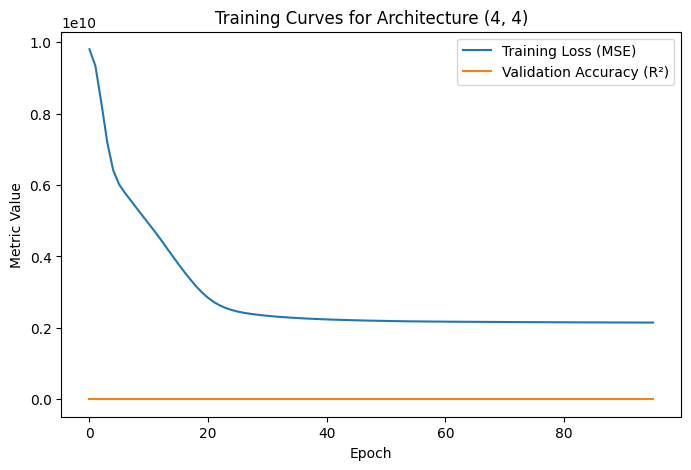

Number of epochs: 96
Training Set Metrics:
  Coefficient of Determination (R²): 0.6423
  MSE: 2111214848.0000
  MAE: 21610.4570
Test Set Metrics:
  Coefficient of Determination (R²): 0.6441
  MSE: 2083104640.0000
  MAE: 21548.5684
Generalization Gap (Train R² - Test R²): -0.0018

---------------------------------------------------
Architecture: (10, 6)
Epoch 1/200
1750/1750 [==============================] - 4s 2ms/step - loss: 9785273344.0000 - r2_metric: -0.2944 - mae: 39209.0000 - val_loss: 9824879616.0000 - val_r2_metric: -0.2576 - val_mae: 38132.2539
Epoch 2/200
1750/1750 [==============================] - 3s 2ms/step - loss: 9195289600.0000 - r2_metric: -0.1816 - mae: 38266.8359 - val_loss: 8782915584.0000 - val_r2_metric: -0.0602 - val_mae: 36526.9727
Epoch 3/200
1750/1750 [==============================] - 3s 2ms/step - loss: 7843639808.0000 - r2_metric: 0.0527 - mae: 36441.6914 - val_loss: 7275323904.0000 - val_r2_metric: 0.1618 - val_mae: 35120.0703
Epoch 4/200
1750/1750 [===

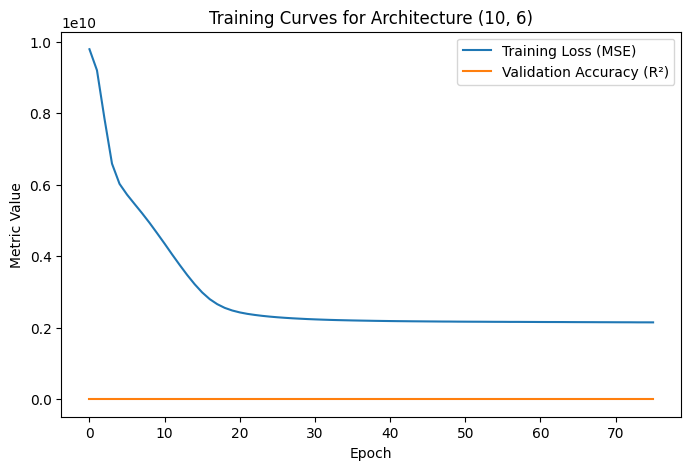

Number of epochs: 76
Training Set Metrics:
  Coefficient of Determination (R²): 0.6403
  MSE: 2116347264.0000
  MAE: 21649.5898
Test Set Metrics:
  Coefficient of Determination (R²): 0.6427
  MSE: 2091344896.0000
  MAE: 21602.1426
Generalization Gap (Train R² - Test R²): -0.0023

---------------------------------------------------
Architecture: (32, 16)
Epoch 1/200
1750/1750 [==============================] - 4s 2ms/step - loss: 9587857408.0000 - r2_metric: -0.2553 - mae: 38891.7500 - val_loss: 9104279552.0000 - val_r2_metric: -0.1188 - val_mae: 36998.8086
Epoch 2/200
1750/1750 [==============================] - 3s 2ms/step - loss: 7732386304.0000 - r2_metric: 0.0636 - mae: 36468.2578 - val_loss: 6880854016.0000 - val_r2_metric: 0.1931 - val_mae: 35224.1016
Epoch 3/200
1750/1750 [==============================] - 3s 2ms/step - loss: 6205424640.0000 - r2_metric: 0.2072 - mae: 36529.6172 - val_loss: 6069499392.0000 - val_r2_metric: 0.1674 - val_mae: 36512.4180
Epoch 4/200
1750/1750 [====

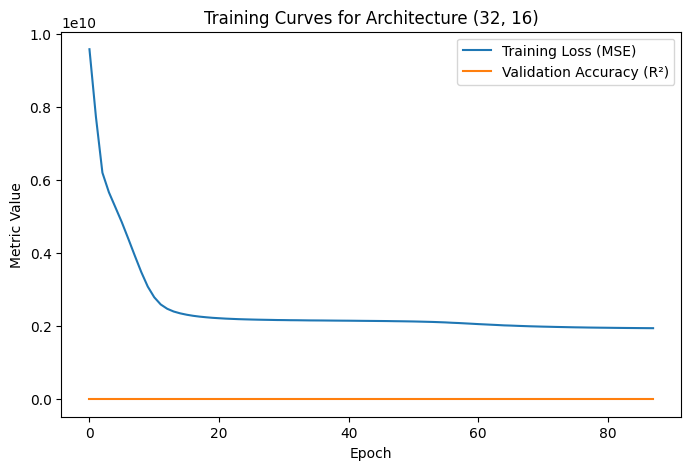

Number of epochs: 88
Training Set Metrics:
  Coefficient of Determination (R²): 0.6762
  MSE: 1932644864.0000
  MAE: 19447.5098
Test Set Metrics:
  Coefficient of Determination (R²): 0.6726
  MSE: 1948355712.0000
  MAE: 19619.4688
Generalization Gap (Train R² - Test R²): 0.0036

---------------------------------------------------
Architecture: (8, 3, 5)
Epoch 1/200
1750/1750 [==============================] - 4s 2ms/step - loss: 9520747520.0000 - r2_metric: -0.2416 - mae: 38812.6875 - val_loss: 8567071232.0000 - val_r2_metric: -0.0223 - val_mae: 36293.2852
Epoch 2/200
1750/1750 [==============================] - 3s 2ms/step - loss: 6739769344.0000 - r2_metric: 0.1551 - mae: 36732.3984 - val_loss: 6118543360.0000 - val_r2_metric: 0.1564 - val_mae: 36851.2969
Epoch 3/200
1750/1750 [==============================] - 3s 2ms/step - loss: 5623535104.0000 - r2_metric: 0.1923 - mae: 36877.4453 - val_loss: 5462344192.0000 - val_r2_metric: 0.1595 - val_mae: 35693.0312
Epoch 4/200
1750/1750 [====

In [ ]:
def main():
    # Step 1: Read in and preprocess the dataset
    X, y = preprocess_data("Census_Supplement_Data.xlsx")
    
    # Step 2: Split the data into training (70%) and test (30%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Step 3: Normalize the data using StandardScaler (fit on training set only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Define the list of neural network architectures to try.
    architectures = [
        (4, 4),
        (10, 6),
        (32, 16),
        (8, 3, 5),
        (12, 9, 10)
    ]
    
    results = []
    # For each architecture, build, train, and evaluate the model.
    for arch in architectures:
        res = train_and_evaluate_model(X_train, X_test, y_train, y_test, arch)
        results.append(res)
    
    # Display a summary table of results
    results_df = pd.DataFrame(results)
    print("Summary of Model Performances:")
    print(results_df)

if __name__ == '__main__':
    main()
